## Import

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Load

In [2]:
# Load historical data
file_path_anleihen_indices = "./data/Anleihen und Indizes historische Zinsen.xlsx"
file_path_festgeld_tagesgeld = "./data/Handelsblatt_Spezial.xlsx"
file_path_etf = "./data/ETFs.xlsx"
file_path_inflation = "./data/Inflation_historisch_final.xlsx"

df_anleihen = pd.read_excel(file_path_anleihen_indices, sheet_name="Anleihen", skiprows=2)
df_indices = pd.read_excel(file_path_anleihen_indices, sheet_name="Indizes")
df_festgeld_tagesgeld= pd.read_excel(file_path_festgeld_tagesgeld, sheet_name="Monatswert", skiprows=1)
df_etf= pd.read_excel(file_path_etf, sheet_name="ETFs")
df_inflation= pd.read_excel(file_path_inflation, skiprows=2)

## Cleaning

In [3]:
df_anleihen = df_anleihen.drop(df_anleihen.columns[[6, 11, 12, 13, 14, 15]], axis=1)
df_anleihen.columns = ["date", "Australien", "Kanada", "Frankreich", "Deutschland", "Japan", "Spanien", "Schweiz", "Großbritannien", "USA"]

df_indices.columns = ["date", "Dow Jones", "S&P-500", "S&P/TSX Composite", "CAC 40", "FTSE 100", "Bovespa", "Shanghai Composite", "Korea Composite", "NIKKEI 225", "IBEX 35", "S&P/ASX 50", "OMX Stockholm", "HANG SENG", "BSE SENSEX", "DAX", "FTSE All"]

df_festgeld_tagesgeld.columns = ['date', '6 Monate', '1 Jahr', '2 Jahre', '5 Jahre', '10 Jahre', 'Tagesgeld', "Inflation_Deutschland"]
df_festgeld_tagesgeld['date'] = pd.to_datetime(df_festgeld_tagesgeld['date'])
df_festgeld_tagesgeld['date'] = df_festgeld_tagesgeld['date'].dt.year

df_etf.columns = ["date", "MSCI World", "MSCI Emerging Markets", "FTSE All World", "S&P Europe 600", "NASDAQ 100"]

df_inflation = df_inflation.drop(df_inflation.columns[[6, 7, 8, 9]], axis=1)
df_inflation.columns = ["date", "Australien", "Kanada", "Deutschland", "Frankreich", "Japan", "Spanien", "Schweiz", "Großbritannien", "USA"]


##### Reduce Anleihen by inflation

In [4]:
# Extract the year from the 'date' column
df_anleihen['date'] = df_anleihen['date'].astype(str).str.extract(r'(\d{4})')[0]
df_inflation['date'] = df_inflation['date'].astype(str).str.extract(r'(\d{4})')[0]

# Convert the extracted year to datetime format
df_anleihen['date'] = pd.to_datetime(df_anleihen['date'], format='%Y', errors='coerce')
df_inflation['date'] = pd.to_datetime(df_inflation['date'], format='%Y', errors='coerce')

# Drop rows with invalid dates
df_anleihen = df_anleihen.dropna(subset=['date'])
df_inflation = df_inflation.dropna(subset=['date'])

df_anleihen.set_index('date', inplace=True)
df_inflation.set_index('date', inplace=True)

# Reorder the columns in df_inflation to match the order of columns in df_anleihen
df_inflation = df_inflation[df_anleihen.columns]

# Subtract values in df_inflation from df_anleihen where both values exist
df_inflation = df_anleihen.subtract(df_inflation, fill_value=np.nan)

# Reset the index to bring 'date' back as a column and convert it to year format
df_inflation.reset_index(inplace=True)
df_inflation['date'] = df_inflation['date'].dt.year

# Define the desired column order
desired_order = [
    "date",  
    "USA",
    "Deutschland",
    "Schweiz",
    "Großbritannien",
    "Japan",
    "Frankreich",
    "Spanien",
    "Kanada",
    "Australien"
]

# Reorder the columns in df_anleihen and df_inflation
df_anleihen = df_anleihen.reset_index()[["date"] + desired_order[1:]]  # Include 'date' explicitly
df_inflation = df_inflation[desired_order]  # Ensure 'date' remains in the desired order

# Display the updated DataFrame
df_anleihen.head()
df_inflation.head()

,date,USA,Deutschland,Schweiz,Großbritannien,Japan,Frankreich,Spanien,Kanada,Australien
0,1950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1953,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1954,2.081667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Reduce Tages- & Festgeld by inflation

In [5]:
# Convert all columns except 'date' to numeric, coercing errors to NaN
numeric_columns = df_festgeld_tagesgeld.columns.difference(['date'])
df_festgeld_tagesgeld[numeric_columns] = df_festgeld_tagesgeld[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Group by date and calculate the yearly values
def calculate_yearly_growth(group):
    results = {}
    for column in group.columns:
        count = group[column].count()
        if count == 0:  
            results[column] = np.nan
        else:
            results[column] = (np.prod(group[column].dropna() + 1) ** (1 / count)) - 1
    return pd.Series(results)

# Group by year and calculate the yearly values
df_festgeld_tagesgeld_yearly = df_festgeld_tagesgeld.groupby('date')[numeric_columns].apply(calculate_yearly_growth).reset_index()

# Ensure the 'date' column remains in year format
df_festgeld_tagesgeld_yearly['date'] = df_festgeld_tagesgeld_yearly['date'].astype(int)

# Subtract the value in 'Inflation_Deutschland' from every other column in the same row
df_festgeld_tagesgeld_yearly[numeric_columns] = df_festgeld_tagesgeld_yearly[numeric_columns].sub(
    df_festgeld_tagesgeld_yearly['Inflation_Deutschland'], axis=0
)

# Drop the 'Inflation_Deutschland' column
df_festgeld_tagesgeld_yearly = df_festgeld_tagesgeld_yearly.drop(columns=['Inflation_Deutschland'])

# Split into df_festgeld and df_tagesgeld
df_festgeld = df_festgeld_tagesgeld_yearly[['date', '6 Monate', '1 Jahr', '2 Jahre', '5 Jahre', '10 Jahre']]
df_tagesgeld = df_festgeld_tagesgeld_yearly[['date', 'Tagesgeld']]

# Display the resulting DataFrames
df_festgeld.head(10)

,date,6 Monate,1 Jahr,2 Jahre,5 Jahre,10 Jahre
0,1994,1.255601,1.629010,2.358809,3.071457,3.635168
1,1995,1.931374,2.279073,3.271378,4.510041,5.138240
2,1996,1.305996,1.461607,2.337054,3.688200,4.763008
3,1997,0.829367,1.044085,1.679422,2.852342,3.882231
4,1998,2.074893,2.310220,2.860354,3.587562,4.332839
5,1999,1.966446,2.125932,2.609831,3.296242,4.043898
6,2000,1.925889,2.245995,2.920938,3.635598,4.194538
7,2001,1.434226,1.582802,2.043698,2.543537,3.058751
8,2002,1.249279,1.478143,2.021159,2.760313,3.351631
9,2003,0.918918,1.031854,1.388819,2.207701,3.074446


##### Reduce Indices by inflation

In [6]:
# Drop the specified columns from df_indices
columns_to_drop = ['Bovespa', 'IBEX 35', 'OMX Stockholm', 'S&P/ASX 50', 'S&P/TSX Composite']
df_indices = df_indices.drop(columns=columns_to_drop, errors='ignore')

# Clean the 'date' column in df_inflation
df_inflation['date'] = df_inflation['date'].astype(str).str.extract(r'(\d{4})')[0]  # Extract the year
df_inflation['date'] = pd.to_datetime(df_inflation['date'], format='%Y', errors='coerce')  # Convert to datetime

# Drop rows with invalid dates
df_inflation = df_inflation.dropna(subset=['date'])

# Ensure the 'date' column in df_indices is in datetime format
df_indices['date'] = pd.to_datetime(df_indices['date'], format='%Y')  # Convert year-only format to datetime
df_indices['date'] = df_indices['date'].dt.strftime('%Y-01-01')  # Standardize to 'YYYY-01-01'
df_indices['date'] = pd.to_datetime(df_indices['date'])  # Convert back to datetime

# Merge df_indices with the 'USA' column of df_inflation on the 'date' column
df_indices = pd.merge(df_indices, df_inflation[['date', 'USA']], on='date', how='left')

# Subtract the 'USA' column from all other columns in df_indices
numeric_columns_indices = df_indices.columns.difference(['date', 'USA'])
df_indices[numeric_columns_indices] = df_indices[numeric_columns_indices].sub(df_indices['USA'], axis=0)

# Drop the 'USA' column after adjustment
df_indices = df_indices.drop(columns=['USA'])

# Extract the year from the 'date' column
df_indices['date'] = df_indices['date'].dt.year
df_inflation['date'] = df_inflation['date'].dt.year

# Define the desired column order
desired_order = [
    "Dow Jones",
    "S&P-500",
    "DAX",
    "FTSE 100",
    "FTSE All",
    "NIKKEI 225",
    "Shanghai Composite",
    "BSE SENSEX",
    "HANG SENG",
    "CAC 40",
    "Korea Composite"
]

# Reorder the columns in df_indices
df_indices = df_indices[["date"] + desired_order]  # Ensure 'date' remains the first column

# Display the reordered DataFrame
df_indices.head(10)

,date,Dow Jones,S&P-500,DAX,FTSE 100,FTSE All,NIKKEI 225,Shanghai Composite,BSE SENSEX,HANG SENG,CAC 40,Korea Composite
0,1955,16.348661,NaN,NaN,NaN,NaN,16.448953,NaN,NaN,NaN,NaN,NaN
1,1956,0.604085,NaN,NaN,NaN,NaN,27.337477,NaN,NaN,NaN,NaN,NaN
2,1957,-13.077036,NaN,NaN,NaN,NaN,-14.440508,NaN,NaN,NaN,NaN,NaN
3,1958,33.384093,NaN,NaN,NaN,NaN,40.344151,NaN,NaN,NaN,NaN,NaN
4,1959,13.075194,NaN,NaN,NaN,NaN,28.340524,NaN,NaN,NaN,NaN,NaN
5,1960,-12.001308,NaN,NaN,NaN,NaN,52.415148,NaN,NaN,NaN,NaN,NaN
6,1961,15.900981,NaN,NaN,NaN,NaN,2.781903,NaN,NaN,NaN,NaN,NaN
7,1962,-13.557575,NaN,NaN,NaN,NaN,-3.596564,NaN,NaN,NaN,NaN,NaN
8,1963,14.236096,NaN,NaN,NaN,12.415930,-15.908850,NaN,NaN,NaN,NaN,NaN
9,1964,11.664629,10.06212,NaN,NaN,-12.954591,-4.297882,NaN,NaN,NaN,NaN,NaN


##### Reduce ETFs by inflation

In [7]:
# Ensure the 'date' column in df_etf is in year format to match df_inflation
df_etf['date'] = pd.to_datetime(df_etf['date'], format='%Y', errors='coerce')  # Convert year-only format to datetime
df_etf['date'] = df_etf['date'].dt.year  # Extract only the year

# Ensure the 'date' column in df_inflation is in year format
df_inflation['date'] = pd.to_datetime(df_inflation['date'], format='%Y', errors='coerce')  # Convert year-only format to datetime
df_inflation['date'] = df_inflation['date'].dt.year  # Extract only the year

# Merge df_etf with the 'USA' column of df_inflation on the 'date' column
df_etf = pd.merge(df_etf, df_inflation[['date', 'USA']], on='date', how='left')

# Subtract the 'USA' column from all other columns in df_etf
numeric_columns_etf = df_etf.columns.difference(['date', 'USA'])
df_etf[numeric_columns_etf] = df_etf[numeric_columns_etf].sub(df_etf['USA'], axis=0)

# Drop the 'USA' column after adjustment
df_etf = df_etf.drop(columns=['USA'])

# Define the desired column order
desired_order = [
    "date",
    "MSCI World",
    "MSCI Emerging Markets",
    "FTSE All World",
    "NASDAQ 100",
    "S&P Europe 600"
]

# Reorder the columns in df_etf
df_etf = df_etf[desired_order]

# Display the reordered DataFrame
df_etf.head(20)

,date,MSCI World,MSCI Emerging Markets,FTSE All World,NASDAQ 100,S&P Europe 600
0,1969,NaN,NaN,NaN,NaN,NaN
1,1970,-3.493078,NaN,NaN,NaN,NaN
2,1971,17.697553,NaN,NaN,NaN,NaN
3,1972,20.610613,NaN,NaN,NaN,NaN
4,1973,-15.170576,NaN,NaN,NaN,NaN
5,1974,-20.982649,NaN,NaN,NaN,NaN
6,1975,35.651389,NaN,NaN,NaN,NaN
7,1976,12.843800,NaN,NaN,NaN,NaN
8,1977,1.084209,NaN,NaN,NaN,NaN
9,1978,17.437325,NaN,NaN,NaN,NaN


## Restructuring

In [8]:
kennung_dic = {
    "USA": "Staatsanleihe USA (10 Jahre)",
    "Deutschland": "Staatsanleihe Deutschland (10 Jahre)",
    "Schweiz": "Staatsanleihe Schweiz (10 Jahre)",
    "Großbritannien": "Staatsanleihe Großbritannien (10 Jahre)",
    "Japan": "Staatsanleihe Japan (10 Jahre)",
    "Frankreich": "Staatsanleihe Frankreich (10 Jahre)",
    "Spanien": "Staatsanleihe Spanien (10 Jahre)",
    "Kanada": "Staatsanleihe Kanada (10 Jahre)",
    "Australien": "Staatsanleihe Australien (10 Jahre)",
    "Dow Jones": "Dow Jones",
    "S&P-500": "S&P 500",
    "DAX": "DAX",
    "FTSE 100": "FTSE 100",
    "FTSE All": "FTSE All",
    "NIKKEI 225": "NIKKEI 225",
    "Shanghai Composite": "Shanghai Composite",
    "BSE SENSEX": "BSE SENSEX",
    "HANG SENG": "HANG SENG",
    "CAC 40": "CAC 40",
    "Korea Composite": "Korea Composite",
    "MSCI World": "MSCI World",
    "MSCI Emerging Markets": "MSCI Emerging Markets",
    "FTSE All World": "FTSE All World",
    "NASDAQ 100": "NASDAQ 100",
    "S&P Europe 600": "S&P Europe 600",
    "6 Monate": "Durchschnitt deutscher Banken",
    "1 Jahr": "Durchschnitt deutscher Banken",
    "2 Jahre": "Durchschnitt deutscher Banken",
    "5 Jahre": "Durchschnitt deutscher Banken",
    "10 Jahre": "Durchschnitt deutscher Banken",
    "Tagesgeld": "Durchschnitt deutscher Banken"
}

label_dic = {
    "USA": "USA",
    "Deutschland": "Deutschland",
    "Schweiz": "Schweiz",
    "Großbritannien": "Großbritannien",
    "Japan": "Japan",
    "Frankreich": "Frankreich",
    "Spanien": "Spanien",
    "Kanada": "Kanada",
    "Australien": "Australien",
    "Dow Jones": "USA",
    "S&P-500": "USA",
    "DAX": "Deutschland",
    "FTSE 100": "Großbritannien",
    "FTSE All": "Großbritannien",
    "NIKKEI 225": "Japan",
    "Shanghai Composite": "China",
    "BSE SENSEX": "Indien",
    "HANG SENG": "Hongkong",
    "CAC 40": "Frankreich",
    "Korea Composite": "Südkorea",
    "MSCI World": "Weltweit",
    "MSCI Emerging Markets": "Schwellenländer",
    "FTSE All World": "Weltweit",
    "NASDAQ 100": "Technologiewerte",
    "S&P Europe 600": "Europa",
    "6 Monate": "Festgeld",
    "1 Jahr": "Festgeld",
    "2 Jahre": "Festgeld",
    "5 Jahre": "Festgeld",
    "10 Jahre": "Festgeld",
    "Tagesgeld": "Tagesgeld"
}

sublabel_dic = {
    "USA": "Anleihe",
    "Deutschland": "Anleihe",
    "Schweiz": "Anleihe",
    "Großbritannien": "Anleihe",
    "Japan": "Anleihe",
    "Frankreich": "Anleihe",
    "Spanien": "Anleihe",
    "Kanada": "Anleihe",
    "Australien": "Anleihe",
    "Dow Jones": "Länder-ETF",
    "S&P-500": "Länder-ETF",
    "DAX": "Länder-ETF",
    "FTSE 100": "Länder-ETF",
    "FTSE All": "Länder-ETF",
    "NIKKEI 225": "Länder-ETF",
    "Shanghai Composite": "Länder-ETF",
    "BSE SENSEX": "Länder-ETF",
    "HANG SENG": "Länder-ETF",
    "CAC 40": "Länder-ETF",
    "Korea Composite": "Länder-ETF",
    "MSCI World": "ETF",
    "MSCI Emerging Markets": "ETF",
    "FTSE All World": "ETF",
    "NASDAQ 100": "ETF",
    "S&P Europe 600": "ETF",
    "6 Monate": "6 Monate",
    "1 Jahr": "1 Jahr",
    "2 Jahre": "2 Jahre",
    "5 Jahre": "5 Jahre",
    "10 Jahre": "10 Jahre",
    "Tagesgeld": ""
}

##### 1. Medianberechnung

In [9]:
# Define the range of years
year_range = range(1, 31)  

# Initialize the structure for the JSON
json_structure = {
    "assets": []
}

# Define the function to convert numpy types and pandas.Timestamp to native Python types for JSON serialization
def convert_numpy_types(obj):
    if isinstance(obj, (np.int64, np.int32)):
        return int(obj)
    elif isinstance(obj, (np.float64, np.float32)):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, pd.Timestamp):  
        return obj.strftime('%Y')  
    else:
        raise TypeError(f"Object of type {type(obj)} is not JSON serializable")

# Function to process columns and add them to the JSON structure
def process_columns(df, category, date_column_name="date"):
    for column_name in df.columns:
        if column_name == date_column_name:
            continue  

        growth_column = df[column_name]
        date_column = df[date_column_name]

        # Determine the category dynamically for Festgeld and Tagesgeld
        if "Festgeld" in column_name:
            column_category = "Festgeld"
        elif "Tagesgeld" in column_name:
            column_category = "Tagesgeld"
        else:
            column_category = category  

        # Determine the country dynamically for indices
        kennung_name = kennung_dic.get(column_name, "Unknown") 
        label_name = label_dic.get(column_name, "Unknown") 
        sublabel_name = sublabel_dic.get(column_name, "Unknown")  

        # Add a new asset entry for the current column
        asset_entry = {
            "category": column_category,
            "sublabel": sublabel_name,
            "kennung": kennung_name,
            "id": f"{column_category}_{column_name}",
            "label": label_name, 
            "data": [] 
        }

        # Iterate through all values of year
        for year in year_range:
            
            highest_value = float('-inf')
            lowest_value = float('inf')
            highest_year = None
            lowest_year = None
            highest_values_list = []  
            lowest_values_list = [] 
            median_values_list = []  
            values_with_years = [] 

            # Iterate through all rows where there are numbers
            valid_growths = growth_column.dropna()
            valid_dates = date_column[~growth_column.isna()]  

            for i in range(len(valid_growths) - year + 1): 
                value = 1
                growth_array = [] 
                for growth in valid_growths[i:i + year]:
                    value *= (1 + growth / 100)  
                    growth_array.append(round(growth, 2))  
                
                values_with_years.append((value, valid_dates.iloc[i], growth_array))  
                if value > highest_value:
                    highest_value = value
                    highest_year = valid_dates.iloc[i]
                    highest_values_list = growth_array  
                if value < lowest_value:
                    lowest_value = value
                    lowest_year = valid_dates.iloc[i]
                    lowest_values_list = growth_array  

            # Calculate the median value and find its corresponding year and array
            if values_with_years:  
                sorted_values = sorted(values_with_years, key=lambda v: v[0])
                median_index = len(sorted_values) // 2
                median_value, median_year, median_values_list = sorted_values[median_index]

                # Create dictionaries for max, median, and min arrays
                max_dict = {
                    "type": "max",
                    "duration": year, 
                    "year": highest_year,  
                    "growth_array": highest_values_list
                }
                median_dict = {
                    "type": "median",
                    "duration": year,  
                    "year": median_year, 
                    "growth_array": median_values_list
                }
                min_dict = {
                    "type": "min",
                    "duration": year, 
                    "year": lowest_year, 
                    "growth_array": lowest_values_list
                }

                # Append the dictionaries to the "data" key in the asset entry
                asset_entry["data"].extend([max_dict, median_dict, min_dict])
            else:
                print(f"No valid values for column '{column_name}' and year = {year}. Skipping...")

        # Append the asset entry to the JSON structure
        json_structure["assets"].append(asset_entry)

# Process df_anleihen_clean, df_indices, and df_festgeld_tagesgeld_yearly
process_columns(df_indices, "Länder-ETF", date_column_name="date")
process_columns(df_etf, "ETF", date_column_name="date")
process_columns(df_inflation, "Anleihe", date_column_name="date")
process_columns(df_festgeld, "Festgeld", date_column_name="date")
process_columns(df_tagesgeld, "Tagesgeld", date_column_name="date")

# Save the JSON structure to a file
with open("export/data_1.json", "w") as json_file:
    json.dump(json_structure, json_file, separators=(",", ":"), default=convert_numpy_types)

##### 2. Medianberechnung

In [ ]:
# Define the range of years
year_range = range(1, 31)  

# Initialize the structure for the JSON
json_structure = {
    "assets": []
}

# Define the function to convert numpy types and pandas.Timestamp to native Python types for JSON serialization
def convert_numpy_types(obj):
    if isinstance(obj, (np.int64, np.int32)):
        return int(obj)
    elif isinstance(obj, (np.float64, np.float32)):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, pd.Timestamp):  
        return obj.strftime('%Y')  
    else:
        raise TypeError(f"Object of type {type(obj)} is not JSON serializable")

# Function to process columns and add them to the JSON structure
def process_columns(df, category, date_column_name="date"):
    for column_name in df.columns:
        if column_name == date_column_name:
            continue  

        growth_column = df[column_name]
        date_column = df[date_column_name]

        # Determine the category dynamically for Festgeld and Tagesgeld
        if "Festgeld" in column_name:
            column_category = "Festgeld"
        elif "Tagesgeld" in column_name:
            column_category = "Tagesgeld"
        else:
            column_category = category  

        # Determine the country dynamically for indices
        kennung_name = kennung_dic.get(column_name, "Unknown") 
        label_name = label_dic.get(column_name, "Unknown") 
        sublabel_name = sublabel_dic.get(column_name, "Unknown")  

        # Add a new asset entry for the current column
        asset_entry = {
            "category": column_category,
            "sublabel": sublabel_name,
            "kennung": kennung_name,
            "id": f"{column_category}_{column_name}",
            "label": label_name, 
            "data": [] 
        }

        # Iterate through all values of year
        for year in year_range:
            
            highest_value = float('-inf')
            lowest_value = float('inf')
            highest_year = None
            lowest_year = None
            highest_values_list = []  
            lowest_values_list = [] 
            median_values_list = []  
            values_with_years = [] 

            # Iterate through all rows where there are numbers
            valid_growths = growth_column.dropna()
            valid_dates = date_column[~growth_column.isna()]  

            for i in range(len(valid_growths) - year + 1): 
                value = 1
                growth_array = [] 
                for growth in valid_growths[i:i + year]:
                    value *= (1 + growth / 100)  
                    growth_array.append(round(growth, 2))  
                
                values_with_years.append((value, valid_dates.iloc[i], growth_array))  
                if value > highest_value:
                    highest_value = value
                    highest_year = valid_dates.iloc[i]
                    highest_values_list = growth_array  
                if value < lowest_value:
                    lowest_value = value
                    lowest_year = valid_dates.iloc[i]
                    lowest_values_list = growth_array  

            # Calculate the median value based on max and min
            if highest_values_list and lowest_values_list:
                median_values_list = [round((max_val + min_val) / 2, 2) for max_val, min_val in zip(highest_values_list, lowest_values_list)]

                # Create dictionaries for max, median, and min arrays
                max_dict = {
                    "type": "max",
                    "duration": year, 
                    "year": highest_year,  
                    "growth_array": highest_values_list
                }
                median_dict = {
                    "type": "median",
                    "duration": year,  
                    "year": None,  
                    "growth_array": median_values_list
                }
                min_dict = {
                    "type": "min",
                    "duration": year, 
                    "year": lowest_year, 
                    "growth_array": lowest_values_list
                }

                # Append the dictionaries to the "data" key in the asset entry
                asset_entry["data"].extend([max_dict, median_dict, min_dict])
            else:
                print(f"No valid values for column '{column_name}' and year = {year}. Skipping...")

        # Append the asset entry to the JSON structure
        json_structure["assets"].append(asset_entry)

# Process df_anleihen_clean, df_indices, and df_festgeld_tagesgeld_yearly
process_columns(df_inflation, "Anleihe", date_column_name="date")
process_columns(df_indices, "Index", date_column_name="date")
process_columns(df_festgeld, "Festgeld", date_column_name="date")
process_columns(df_tagesgeld, "Tagesgeld", date_column_name="date")
process_columns(df_etf, "ETF", date_column_name="date")

# Save the JSON structure to a file
with open("export/data_2.json", "w") as json_file:
    json.dump(json_structure, json_file, separators=(",", ":"), default=convert_numpy_types)

## Prüfung

##### Prüfung: Extremwert / Nasdaq / 22 Jahre

In [74]:
# Wachstumsdaten für 22 Jahre
growth_data = {
    "max":      [47.66,9.1,1.0,5.63,17.42,-41.43,50.99,18.53,3.97,18.57,36.01,18.48,7.68,6.72,32.8,-0.47,39.17,49.24,30.76,-27.35,55.26,24.64],
    "median":   [4.1,-12.84,-19.76,26.64,13.26,-20.21,28.31,17.98,-18.73,34.78,27.27,11.22,13.12,21.36,25.64,3.6,22.95,41.02,15.15,5.91,52.25,27.7],
    "min":      [-39.45,-34.79,-40.52,47.66,9.1,1.0,5.63,17.42,-41.43,50.99,18.53,3.97,18.57,36.01,18.48,7.68,6.72,32.8,-0.47,39.17,49.24,30.76]
}

def endkapital(startkapital, monatlich, renditen):
    kapital = startkapital
    for jahr in range(len(renditen)):
        monatszins = (1 + renditen[jahr] / 100) ** (1/12) - 1  
        for m in range(12):
            kapital = kapital * (1 + monatszins) + monatlich
    return kapital

# Parameter
startkapital = 10
monatlich = 0

# Berechnung des finalen Kapitals für alle Wachstumsreihen
results = {}
for key, growth_array in growth_data.items():
    finales_kapital = endkapital(startkapital, monatlich, growth_array)
    results[key] = finales_kapital

# Ausgabe der Ergebnisse
for key, value in results.items():
    print(f"{key.capitalize()}: {value:.2f} €")

Max: 243.71 €
Median: 143.66 €
Min: 40.71 €


##### Prüfung  auf Median-Fehler (1. Medianberechnung)

In [ ]:
# Lade die Daten aus der JSON-Datei
with open("export/data_1.json", "r") as json_file:
    json_data = json.load(json_file)

# Funktion zur Berechnung des Endkapitals
def endkapital(startkapital, monatlich, renditen):
    kapital = startkapital
    for jahr in range(len(renditen)):
        monatszins = (1 + renditen[jahr] / 100) ** (1/12) - 1  
        for m in range(12):
            kapital = kapital * (1 + monatszins) + monatlich
    return kapital

# Parameter
total_durations = 29  # Anzahl der durations (2 bis 30)
total_invalid_durations = 0  # Zähler für ungültige durations über alle Startkapitalwerte und monatlich hinweg
total_checks = 0  # Gesamtanzahl der überprüften durations

# Loop durch alle monatlichen Sparbeträge in 100er-Schritten von 0 bis 2000
for monatlich in range(0, 2001, 100):  # Iteriere durch monatliche Sparbeträge
    print(f"Prüfe für monatlich: {monatlich} €")

    # Loop durch alle Startkapitalwerte in Tausenderschritten von 1000 bis 1000000
    for startkapital in range(1000, 1000001, 1000):  # Iteriere durch Startkapitalwerte

        # Loop durch alle durations von 2 bis 30
        for duration in range(2, 31):  # Iteriere durch durations von 2 bis 30

            # Loop durch alle Assets im JSON
            for asset in json_data["assets"]:
                growth_data = {
                    "max": [],
                    "median": [],
                    "min": []
                }

                # Extrahiere die Wachstumsdaten für die aktuelle duration
                for entry in asset["data"]:
                    if entry["duration"] == duration:  # Prüfe, ob die Dauer der aktuellen entspricht
                        if entry["type"] == "max":
                            growth_data["max"] = entry["growth_array"]
                        elif entry["type"] == "median":
                            growth_data["median"] = entry["growth_array"]
                        elif entry["type"] == "min":
                            growth_data["min"] = entry["growth_array"]

                # Berechnung des finalen Kapitals für alle Wachstumsreihen
                results = {}
                for key, growth_array in growth_data.items():
                    finales_kapital = endkapital(startkapital, monatlich, growth_array)
                    results[key] = finales_kapital

                # Überprüfung der Bedingungen
                max_value = results["max"]
                median_value = results["median"]
                min_value = results["min"]

                total_checks += 1  # Erhöhe die Gesamtanzahl der überprüften durations
                if not (max_value > median_value > min_value):
                    total_invalid_durations += 1  # Erhöhe den Zähler, wenn die Bedingungen nicht erfüllt sind

# Berechnung der Prozentzahl ungültiger durations über alle Startkapitalwerte und monatlich hinweg
invalid_percentage = (total_invalid_durations / total_checks) * 100

# Ausgabe der Prozentzahl ungültiger durations
print(f"Prozentzahl ungültiger durations über alle Startkapitalwerte und monatlich hinweg: {invalid_percentage:.2f}%")

Prüfe für monatlich: 0 €
Prüfe für monatlich: 100 €
Prüfe für monatlich: 200 €
Prüfe für monatlich: 300 €
Prüfe für monatlich: 400 €
Prüfe für monatlich: 500 €
Prüfe für monatlich: 600 €
Prüfe für monatlich: 700 €
Prüfe für monatlich: 800 €
Prüfe für monatlich: 900 €
Prüfe für monatlich: 1000 €
Prüfe für monatlich: 1100 €
Prüfe für monatlich: 1200 €
Prüfe für monatlich: 1300 €
Prüfe für monatlich: 1400 €
Prüfe für monatlich: 1500 €
Prüfe für monatlich: 1600 €
Prüfe für monatlich: 1700 €
Prüfe für monatlich: 1800 €
Prüfe für monatlich: 1900 €
Prüfe für monatlich: 2000 €
Prozentzahl ungültiger durations über alle Startkapitalwerte und monatlich hinweg: 0.96%


##### Prüfung  auf Median-Fehler (2. Medianberechnung)

In [ ]:
# Lade die Daten aus der JSON-Datei
with open("export/data_2.json", "r") as json_file:
    json_data = json.load(json_file)

# Funktion zur Berechnung des Endkapitals
def endkapital(startkapital, monatlich, renditen):
    kapital = startkapital
    for jahr in range(len(renditen)):
        monatszins = (1 + renditen[jahr] / 100) ** (1/12) - 1  
        for m in range(12):
            kapital = kapital * (1 + monatszins) + monatlich
    return kapital

# Parameter
total_durations = 29  # Anzahl der durations (2 bis 30)
total_invalid_durations = 0  # Zähler für ungültige durations über alle Startkapitalwerte und monatlich hinweg
total_checks = 0  # Gesamtanzahl der überprüften durations

# Loop durch alle monatlichen Sparbeträge in 100er-Schritten von 0 bis 2000
for monatlich in range(0, 2001, 100):  # Iteriere durch monatliche Sparbeträge
    print(f"Prüfe für monatlich: {monatlich} €")

    # Loop durch alle Startkapitalwerte in Tausenderschritten von 1000 bis 1000000
    for startkapital in range(1000, 1000001, 1000):  # Iteriere durch Startkapitalwerte

        # Loop durch alle durations von 2 bis 30
        for duration in range(2, 31):  # Iteriere durch durations von 2 bis 30

            # Loop durch alle Assets im JSON
            for asset in json_data["assets"]:
                growth_data = {
                    "max": [],
                    "median": [],
                    "min": []
                }

                # Extrahiere die Wachstumsdaten für die aktuelle duration
                for entry in asset["data"]:
                    if entry["duration"] == duration:  # Prüfe, ob die Dauer der aktuellen entspricht
                        if entry["type"] == "max":
                            growth_data["max"] = entry["growth_array"]
                        elif entry["type"] == "median":
                            growth_data["median"] = entry["growth_array"]
                        elif entry["type"] == "min":
                            growth_data["min"] = entry["growth_array"]

                # Berechnung des finalen Kapitals für alle Wachstumsreihen
                results = {}
                for key, growth_array in growth_data.items():
                    finales_kapital = endkapital(startkapital, monatlich, growth_array)
                    results[key] = finales_kapital

                # Überprüfung der Bedingungen
                max_value = results["max"]
                median_value = results["median"]
                min_value = results["min"]

                total_checks += 1  # Erhöhe die Gesamtanzahl der überprüften durations
                if not (max_value > median_value > min_value):
                    total_invalid_durations += 1  # Erhöhe den Zähler, wenn die Bedingungen nicht erfüllt sind

# Berechnung der Prozentzahl ungültiger durations über alle Startkapitalwerte und monatlich hinweg
invalid_percentage = (total_invalid_durations / total_checks) * 100

# Ausgabe der Prozentzahl ungültiger durations
print(f"Prozentzahl ungültiger durations über alle Startkapitalwerte und monatlich hinweg: {invalid_percentage:.2f}%")

Prüfe für monatlich: 0 €
Prüfe für monatlich: 100 €
Prüfe für monatlich: 200 €
Prüfe für monatlich: 300 €
Prüfe für monatlich: 400 €
Prüfe für monatlich: 500 €
Prüfe für monatlich: 600 €
Prüfe für monatlich: 700 €
Prüfe für monatlich: 800 €
Prüfe für monatlich: 900 €
Prüfe für monatlich: 1000 €
Prüfe für monatlich: 1100 €
Prüfe für monatlich: 1200 €
Prüfe für monatlich: 1300 €
Prüfe für monatlich: 1400 €
Prüfe für monatlich: 1500 €
Prüfe für monatlich: 1600 €
Prüfe für monatlich: 1700 €
Prüfe für monatlich: 1800 €
Prüfe für monatlich: 1900 €
Prüfe für monatlich: 2000 €
Prozentzahl ungültiger durations über alle Startkapitalwerte und monatlich hinweg: 3.74%


##### Prüfung: Gemischte Anlage / 2 Jahre / Summe

In [ ]:
renditen_anleihe = [1.47,3.27]
renditen_dj = [5.06,7.52]

def endkapital(startkapital, monatlich, renditen):
    kapital = startkapital
    for jahr in range(2):
        monatszins = (1 + renditen[jahr] / 100) ** (1/12) - 1  
        for m in range(12):
            kapital = kapital * (1 + monatszins) + monatlich
            print(jahr, m, kapital)
    return kapital

anleihe_final = endkapital(5000, 125, renditen_anleihe)
dowjones_final = endkapital(5000, 125, renditen_dj)
gesamt = anleihe_final + dowjones_final

print(f"Endwert Anleihe: {anleihe_final:.2f} €")
print(f"Endwert Dow Jones: {dowjones_final:.2f} €")
print(f"Gesamtsumme: {gesamt:.2f} €")


##### Prüfung: Anlage / 10 Jahre / Summe

In [57]:
renditen_anleihe = [12.39,20.25,-7.68,-9.29,-19.79,23.58,1.04,-1.01,14.72,4.66,-33.66,15.21,10.34,5.06,7.52,25.61,6.6,-4.25,12.83,24.88,-6.1,22.01]

def endkapital(startkapital, monatlich, renditen):
    kapital = startkapital
    for jahr in range(len(renditen)):
        monatszins = (1 + renditen[jahr] / 100 ) ** (1/12) - 1  # Rendite direkt verwenden
        for m in range(12):
            kapital = kapital * (1 + monatszins) + monatlich
            print(f"Jahr: {jahr}, Monat: {m}, Kapital: {kapital:.2f}")
    return kapital

anleihe_final = endkapital(10000, 250, renditen_anleihe)

print(f"Endwert Anleihe: {anleihe_final:.2f} €")

Jahr: 0, Monat: 0, Kapital: 10347.81
Jahr: 0, Monat: 1, Kapital: 10699.03
Jahr: 0, Monat: 2, Kapital: 11053.68
Jahr: 0, Monat: 3, Kapital: 11411.80
Jahr: 0, Monat: 4, Kapital: 11773.42
Jahr: 0, Monat: 5, Kapital: 12138.58
Jahr: 0, Monat: 6, Kapital: 12507.31
Jahr: 0, Monat: 7, Kapital: 12879.64
Jahr: 0, Monat: 8, Kapital: 13255.62
Jahr: 0, Monat: 9, Kapital: 13635.28
Jahr: 0, Monat: 10, Kapital: 14018.65
Jahr: 0, Monat: 11, Kapital: 14405.77
Jahr: 1, Monat: 0, Kapital: 14878.85
Jahr: 1, Monat: 1, Kapital: 15359.26
Jahr: 1, Monat: 2, Kapital: 15847.11
Jahr: 1, Monat: 3, Kapital: 16342.51
Jahr: 1, Monat: 4, Kapital: 16845.58
Jahr: 1, Monat: 5, Kapital: 17356.44
Jahr: 1, Monat: 6, Kapital: 17875.22
Jahr: 1, Monat: 7, Kapital: 18402.03
Jahr: 1, Monat: 8, Kapital: 18936.99
Jahr: 1, Monat: 9, Kapital: 19480.24
Jahr: 1, Monat: 10, Kapital: 20031.91
Jahr: 1, Monat: 11, Kapital: 20592.11
Jahr: 2, Monat: 0, Kapital: 20705.44
Jahr: 2, Monat: 1, Kapital: 20818.02
Jahr: 2, Monat: 2, Kapital: 20929.

##### Prüfung Gemischte Anlage / Max-Median-Min-Entwicklung bei 22 Jahren

In [ ]:
renditen_anleihe_median = [-5.42,-3.29,-2.08,1.06,0.63,1.51,4.47,4.03,3.85,9.57,7.22,4.37,4.66,4.88,5.88,5.85,7.51,8.21,5.53,7.07,4.58,5.59]
renditen_dj_median = [12.39,20.25,-7.68,-9.29,-19.79,23.58,1.04,-1.01,14.72,4.66,-33.66,15.21,10.34,5.06,7.52,25.61,6.6,-4.25,12.83,24.88,-6.1,22.01]

renditen_anleihe_max = [4.47,4.03,3.85,9.57,7.22,4.37,4.66,4.88,5.88,5.85,7.51,8.21,5.53,7.07,4.58,5.59,6.73,4.63,4.53,1.85,1.21,2.86]
renditen_dj_max = [-3.93,6.0,17.02,-12.81,10.51,14.66,-11.88,20.58,16.8,-2.46,7.08,23.29,-7.49,16.7,0.19,10.88,-2.4,29.68,22.51,18.63,12.39,20.25]

renditen_anleihe_min = [2.64,3.25,2.65,2.03,3.66,1.47,3.27,2.45,1.58,1.62,1.27,1.17,1.21,1.06,0.69,0.77,-0.11,0.07,-1.38,-3.39,-1.66,1.05]
renditen_dj_min = [-12.0,15.9,-13.56,14.24,11.66,8.1,-20.79,12.9,2.9,-16.4,3.31,4.14,11.76,-17.25,-24.08,39.48,15.42,-17.78,-3.93,6.0,17.02,-12.81]

def endkapital(startkapital, monatlich, renditen):
    kapital = startkapital
    for jahr in range(len(renditen)):
        monatszins = (1 + renditen[jahr] / 100) ** (1/12) - 1  # Rendite direkt verwenden
        for m in range(12):
            kapital = kapital * (1 + monatszins) + monatlich
    return kapital

# Calculate final capital for Anleihe
anleihe_final = endkapital(10000, 125, renditen_anleihe)
print(f"Endwert Anleihe: {anleihe_final:.2f} €")

# Calculate final capital for Dow Jones
dj_final = endkapital(10000, 125, renditen_dj)
print(f"Endwert Dow Jones: {dj_final:.2f} €")

# Calculate the total sum of both
gesamt_final = anleihe_final + dj_final
print(f"Gesamtsumme: {gesamt_final:.2f} €")

Endwert Anleihe: 84780.34 €
Endwert Dow Jones: 94503.99 €
Gesamtsumme: 179284.34 €


##### Prüfung Gemischte Anlage / Max-Median-Min-Entwicklung bei 22 Jahren / Visualisierung Verlauf

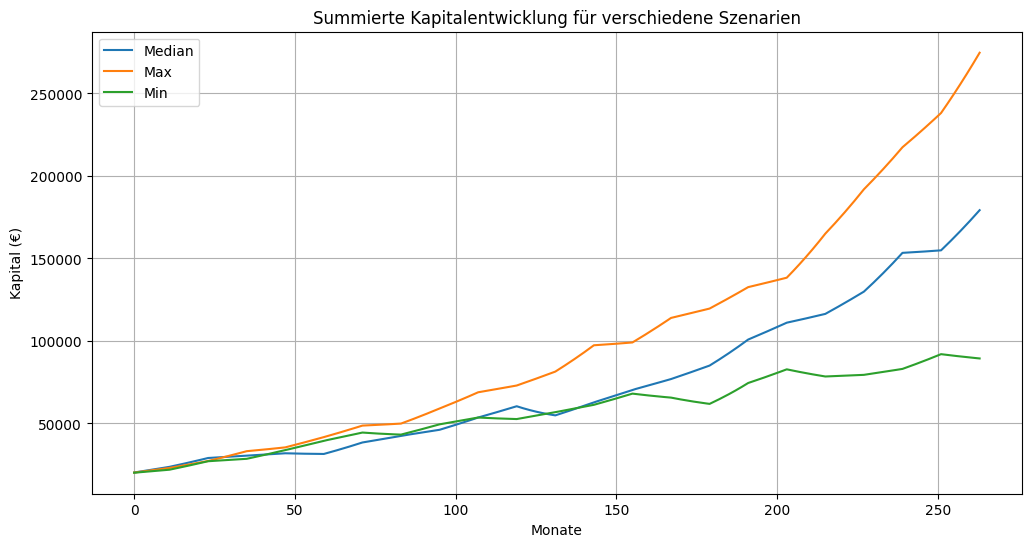

In [64]:
# Data arrays for median, max, and min scenarios
renditen_anleihe_median = [-5.42, -3.29, -2.08, 1.06, 0.63, 1.51, 4.47, 4.03, 3.85, 9.57, 7.22, 4.37, 4.66, 4.88, 5.88, 5.85, 7.51, 8.21, 5.53, 7.07, 4.58, 5.59]
renditen_dj_median = [12.39, 20.25, -7.68, -9.29, -19.79, 23.58, 1.04, -1.01, 14.72, 4.66, -33.66, 15.21, 10.34, 5.06, 7.52, 25.61, 6.6, -4.25, 12.83, 24.88, -6.1, 22.01]

renditen_anleihe_max = [4.47, 4.03, 3.85, 9.57, 7.22, 4.37, 4.66, 4.88, 5.88, 5.85, 7.51, 8.21, 5.53, 7.07, 4.58, 5.59, 6.73, 4.63, 4.53, 1.85, 1.21, 2.86]
renditen_dj_max = [-3.93, 6.0, 17.02, -12.81, 10.51, 14.66, -11.88, 20.58, 16.8, -2.46, 7.08, 23.29, -7.49, 16.7, 0.19, 10.88, -2.4, 29.68, 22.51, 18.63, 12.39, 20.25]

renditen_anleihe_min = [2.64, 3.25, 2.65, 2.03, 3.66, 1.47, 3.27, 2.45, 1.58, 1.62, 1.27, 1.17, 1.21, 1.06, 0.69, 0.77, -0.11, 0.07, -1.38, -3.39, -1.66, 1.05]
renditen_dj_min = [-12.0, 15.9, -13.56, 14.24, 11.66, 8.1, -20.79, 12.9, 2.9, -16.4, 3.31, 4.14, 11.76, -17.25, -24.08, 39.48, 15.42, -17.78, -3.93, 6.0, 17.02, -12.81]

# Function to calculate monthly values
def calculate_monthly_values(startkapital, monatlich, renditen):
    kapital = startkapital
    monthly_values = []
    for jahr in range(len(renditen)):
        monatszins = (1 + renditen[jahr] / 100) ** (1/12) - 1
        for m in range(12):
            kapital = kapital * (1 + monatszins) + monatlich
            monthly_values.append(kapital)
    return monthly_values

# Calculate summed monthly values for all scenarios
summed_median = [
    a + b for a, b in zip(
        calculate_monthly_values(10000, 125, renditen_anleihe_median),
        calculate_monthly_values(10000, 125, renditen_dj_median)
    )
]

summed_max = [
    a + b for a, b in zip(
        calculate_monthly_values(10000, 125, renditen_anleihe_max),
        calculate_monthly_values(10000, 125, renditen_dj_max)
    )
]

summed_min = [
    a + b for a, b in zip(
        calculate_monthly_values(10000, 125, renditen_anleihe_min),
        calculate_monthly_values(10000, 125, renditen_dj_min)
    )
]

# Combine all values into a DataFrame
data = {
    "Median": summed_median,
    "Max": summed_max,
    "Min": summed_min
}
df = pd.DataFrame(data)

# Plot the data
plt.figure(figsize=(12, 6))
for column in df.columns:
    plt.plot(df[column], label=column)

plt.title("Summierte Kapitalentwicklung für verschiedene Szenarien")
plt.xlabel("Monate")
plt.ylabel("Kapital (€)")
plt.legend()
plt.grid()
plt.show()

##### Prüfung: Gemischte Anlage / 10 Jahre / Sparbetrag

In [43]:
renditen_anleihe = [39.48,15.42,-17.78,-3.93,6.0,17.02,-12.81,10.51,14.66,-11.88]

def endkapital(startkapital, monatlich, renditen):
    kapital = startkapital
    for jahr in range(len(renditen)):
        monatszins = (1 + renditen[jahr] / 100) ** (1/12) - 1  # Rendite direkt verwenden
        for m in range(12):
            kapital = kapital * (1 + monatszins) + monatlich
    return kapital

def berechne_monatlich(zielsumme, startkapital, renditen, toleranz=0.01):
    # Set initial bounds for binary search
    lower_bound = 0
    upper_bound = zielsumme
    monatlich = (lower_bound + upper_bound) / 2

    while upper_bound - lower_bound > toleranz:
        kapital = endkapital(startkapital, monatlich, renditen)
        if kapital < zielsumme:
            lower_bound = monatlich  # Increase the lower bound
        else:
            upper_bound = monatlich  # Decrease the upper bound
        monatlich = (lower_bound + upper_bound) / 2  # Update the guess

    return monatlich

# Inputs
zielsumme = 120000  # Target final amount
startkapital = 10000  # Initial capital

# Calculate the required monthly contribution
monatlich = berechne_monatlich(zielsumme, startkapital, renditen_anleihe)

print(f"Benötigter monatlicher Beitrag: {monatlich:.2f} €")

Benötigter monatlicher Beitrag: 810.13 €


##### Prüfung: Gemischte Anlage / Dauer

In [45]:
renditen_anleihe = [-5.42,-3.29,-2.08,1.06,0.63,1.51,4.47,4.03,3.85,9.57,7.22,4.37,4.66,4.88,5.88,5.85,7.51,8.21,5.53,7.07,4.58,5.59]
renditen_dj = [12.39,20.25,-7.68,-9.29,-19.79,23.58,1.04,-1.01,14.72,4.66,-33.66,15.21,10.34,5.06,7.52,25.61,6.6,-4.25,12.83,24.88,-6.1,22.01]

def endkapital(startkapital, monatlich, renditen, jahre):
    kapital = startkapital
    for jahr in range(jahre):
        monatszins = (1 + renditen[jahr % len(renditen)] / 100) ** (1/12) - 1
        for m in range(12):
            kapital = kapital * (1 + monatszins) + monatlich
    return kapital

def berechne_dauer(zielsumme, startkapital, monatlich, renditen_anleihe, renditen_dj):
    jahre = 0
    while True:
        anleihe_final = endkapital(startkapital, monatlich, renditen_anleihe, jahre)
        dowjones_final = endkapital(startkapital, monatlich, renditen_dj, jahre)
        gesamt = anleihe_final + dowjones_final
        if gesamt >= zielsumme:
            break
        jahre += 1
    return jahre

zielsumme = 120000
startkapital = 10000
monatlich = 250

dauer = berechne_dauer(zielsumme, startkapital, monatlich, renditen_anleihe, renditen_dj)

print(f"Benötigte Zeit: {dauer} Jahre")

Benötigte Zeit: 14 Jahre
